In [9]:
import sys
if '/home/andrew/Music/fiesta' not in sys.path:
    sys.path.insert(0, '/home/andrew/Music/fiesta')

In [10]:
from fiesta import util

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import math
import json
from typing import List

In [2]:
#code to rsk our model selection algorithms on a synthetic and TDSA taks

# SYNTHETIC DATA

Text(0, 0.5, 'Reward')

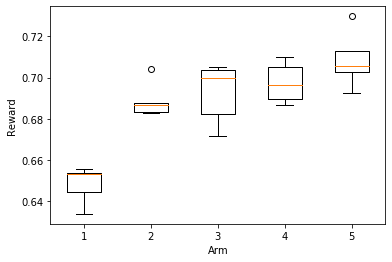

In [28]:
#generate sample data
# arm means
means=[0.65,0.69,0.69,0.70,0.71]
# arm standard deviations
sds=[0.01, 0.01, 0.01, 0.01, 0.01]
#make plot
data=[]
for mean_index, mean in enumerate(means):
    sd = sds[mean_index]
    data_i: List[float] = []
    for j in range(0,5):
        data_i.append(util.pull_arm(mean, sd))
    data.append(data_i)
    
plt.boxplot(data)
plt.xlabel("Arm")
plt.ylabel("Reward")  

In [3]:
def belief_calc(est_means,est_variances,eval_counts,samples):
    #helper funtion for TTTS
    #take in summary stats from observed evals (need to be numpy arrays for vectorization)
    # run for large number of samples e.g 10000
    N=eval_counts.shape[0]
    pi=[0]*N
    #generate samples from t dist with required degrees of freedom
    t_samples=np.random.standard_t(eval_counts-2,(samples,N))
    #scale to get samples from posterior about means
    posterior_samples=t_samples*np.sqrt(est_variances)*np.sqrt(1/(eval_counts-2))+est_means
    #find argmax for each set of samples
    args=np.argmax(posterior_samples,axis=1)
    #count raw frequencies of maximum over samples
    maxs=np.unique(args, return_counts=True)
    pi=[maxs[1][np.where(maxs[0]==model)[0][0]] if model in maxs[0] else 0 for model in range(0,N)]
    #normalize and return
    
    return [p/samples for p in pi]

def TTTS(N,delta):
    #require # models and desired confidence
    #initialize data storage (use lists because will be of different lengths)
    evaluations= [[] for i in range(N)]
    est_means=np.zeros(N)
    est_variances=np.zeros(N)
    #count# evals for each model
    eval_counts=np.zeros(N)
    #start by evaluating each model 3 times
    for i in range(0,N):
        for j in range(0,3):
            evaluations[i].append(pull_arm(i))
        est_means[i]=np.mean(evaluations[i])
        est_variances[i]=np.var(evaluations[i],ddof=0)
        eval_counts[i]=len(evaluations[i])
    #initialize belief about location of best arm 
    pi=belief_calc(est_means,est_variances,eval_counts,100000*N)
    #run TTTS until hit required confidence
    #count number of evals
    num=3*N
    #store running counts of each arm pulled
    props=[]
    pis=[]
    while max(pi)<1-delta:
        props.append([x/sum(eval_counts) for x in eval_counts])
        pis.append(pi)
        #sample m-1
        m_1=np.random.choice(range(0,N), 1, p=pi)[0]
        r=np.random.uniform(0,1)
        if r<=0.5:
            #eval model m_1
            evaluations[m_1].append(pull_arm(m_1))
            #update summary stats
            est_means[m_1]=np.mean(evaluations[m_1])
            est_variances[m_1]=np.var(evaluations[m_1],ddof=0)
            eval_counts[m_1]+=1 
            print("evalaution "+str(num)+" model "+str(m_1))
        else:
            #sample other model
            m_2=np.random.choice(range(0,N), 1, p=pi)[0]
            #resample until unique from model 1
            while m_1==m_2:
                m_2=np.random.choice(range(0,N), 1, p=pi)[0]
            #eval m_2
            evaluations[m_2].append(pull_arm(m_2))
            #update summary stats
            est_means[m_2]=np.mean(evaluations[m_2])
            est_variances[m_2]=np.var(evaluations[m_2],ddof=0)
            eval_counts[m_2]+=1  
            print("evalaution "+str(num)+" model "+str(m_2))
        num+=1
        #update belief
        pi=belief_calc(est_means,est_variances,eval_counts,100000*N)
        print(pi)
    return pi, props,pis
    
    
    
    

In [4]:
def SequentialHalving(N,T):
    # requires number of models N
    # requires computational budget T
    #calc number of rounds
    evaluations=[[] for x in range(0,N)]
    R=math.floor(np.log2(N))
    candidate_names=[x for x in range(0,N)]
    candidate_est_means=[0 for x in range(0,N)]
    round=0
    while len(candidate_names)!=1:
        #calc number of evals for this round
        num_evals=math.floor(T/(len(candidate_names)*math.ceil(np.log2(N))))
        print(num_evals)
        #collect evaluations
        for model in candidate_names:
            for j in range(0,num_evals):
                evaluations[model].append(pull_arm(model))
            #update means
            candidate_est_means[candidate_names.index(model)]=np.mean(evaluations[model])
        #remove approx half models
        for j in range(0,math.floor(len(candidate_names)/2)):
            drop=candidate_names[np.argmin(candidate_est_means)]
            print("in round "+str(round)+" drop model"+str(drop))
            del candidate_names[np.argmin(candidate_est_means)]
            del candidate_est_means[np.argmin(candidate_est_means)]
        round=round+1
        print(candidate_est_means)
    return candidate_names
        
        
            
    

## make plot of TTTS

evalaution 15 model 4
[0.045384, 0.10818, 0.144632, 0.216494, 0.48531]
evalaution 16 model 4
[0.045682, 0.10962, 0.145396, 0.218668, 0.480634]
evalaution 17 model 2
[0.048222, 0.116512, 0.049662, 0.235022, 0.550582]
evalaution 18 model 3
[0.050862, 0.125794, 0.05535, 0.110638, 0.657356]
evalaution 19 model 1
[0.053598, 0.031682, 0.061138, 0.121272, 0.73231]
evalaution 20 model 3
[0.054538, 0.032222, 0.064312, 0.052508, 0.79642]
evalaution 21 model 1
[0.054736, 0.008582, 0.065266, 0.053902, 0.817514]
evalaution 22 model 3
[0.055246, 0.008578, 0.065448, 0.043558, 0.82717]
evalaution 23 model 0
[0.005666, 0.008864, 0.069354, 0.045038, 0.871078]
evalaution 24 model 2
[0.005894, 0.009466, 0.02398, 0.04784, 0.91282]
evalaution 25 model 4
[0.00512, 0.00737, 0.017768, 0.034548, 0.935194]
evalaution 26 model 2
[0.005128, 0.007382, 0.012062, 0.033768, 0.94166]
evalaution 27 model 4
[0.005474, 0.008404, 0.01237, 0.037272, 0.93648]
evalaution 28 model 4
[0.00555, 0.008156, 0.012152, 0.038348, 0.93

Text(0.5,0,'# Evaluations')

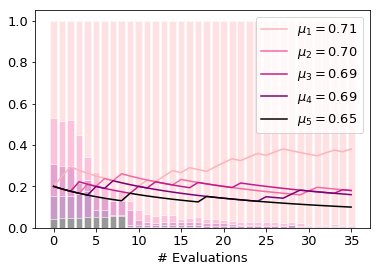

In [39]:
#run TTTS for synthetic problem
np.random.seed(1)
_,counts,pis=TTTS(5,0.01)
plt.rcParams.update({'font.size': 13})
#create stacked bar for belief
plt.bar(range(0,len(pis)), list(np.array(pis)[:,0]), color="black",alpha=0.4, edgecolor='white')
plt.bar(range(0,len(pis)), list(np.array(pis)[:,1]), bottom=list(np.array(pis)[:,0]), color='#7a0177',alpha=0.4, edgecolor='white')
plt.bar(range(0,len(pis)), list(np.array(pis)[:,2]), bottom=[i+j for i,j in zip(list(np.array(pis)[:,0]), list(np.array(pis)[:,1]))], color='#c51b8a',alpha=0.4, edgecolor='white')
plt.bar(range(0,len(pis)), list(np.array(pis)[:,3]), bottom=[i+j+k for i,j,k in zip(list(np.array(pis)[:,0]), list(np.array(pis)[:,1]),list(np.array(pis)[:,2]))], color='#f768a1',alpha=0.4, edgecolor='white')
plt.bar(range(0,len(pis)), list(np.array(pis)[:,4]), bottom=[i+j+k+l for i,j,k,l in zip(list(np.array(pis)[:,0]), list(np.array(pis)[:,1]),list(np.array(pis)[:,2]),list(np.array(pis)[:,3]))], color='#fbb4b9',alpha=0.4, edgecolor='white')
#create lines for proportion evaluated

plt.plot(range(0,len(pis)),list(np.array(counts)[:,4]),color="#fbb4b9",label=r'$\mu_1=0.71$')
plt.plot(range(0,len(pis)),list(np.array(counts)[:,3]),color="#f768a1",label=r'$\mu_2=0.70$')  
plt.plot(range(0,len(pis)),list(np.array(counts)[:,2]),color="#c51b8a",label=r'$\mu_3=0.69$')
plt.plot(range(0,len(pis)),list(np.array(counts)[:,1]),color="#7a0177",label=r'$\mu_4=0.69$')
plt.plot(range(0,len(pis)),list(np.array(counts)[:,0]),color="black",label=r'$\mu_5=0.65$')
plt.legend(loc='upper right')   
plt.xlabel("# Evaluations")    
    
    

# Lets look at 8 TDSA data

In [5]:
from pathlib import Path
data_f = str(Path('/home/andrew/Music/FINALCODE/final_test_f1.json').resolve())

model names are ['atae', 'ian', 'lstm', 'tdlstm', 'atae_50', 'ian_50', 'lstm_50', 'tdlstm_50']


{'whiskers': [<matplotlib.lines.Line2D at 0x7fbc86729470>,
 'caps': [<matplotlib.lines.Line2D at 0x7fbc86729b00>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fbc86729080>,
 'medians': [<matplotlib.lines.Line2D at 0x7fbc867391d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fbc86739518>,
 'means': []}

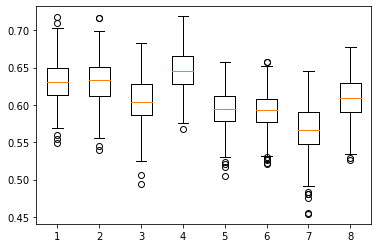

In [6]:
import seaborn as sbn
#load in precomputed results
with open(data_f, 'r') as fp:
    data_dict = json.load(fp)
    
model_names=['atae',  'ian',"lstm","tdlstm",'atae_50', 'ian_50', 'lstm_50', 'tdlstm_50']
print("model names are "+str(model_names))
#define sampler from collected data for a model
def eval_model(model_index):
    '''
    This is in affect a way to get a sample from a model
    '''
    #generate sample from specified arm
    #get name
    name = model_names[model_index]
    return np.random.choice(data_dict[name])



#make plot
plt.boxplot([data_dict[key] for key in model_names])
    

In [7]:
def TTTS_for_TDSA(N,delta):
    #require # models and desired confidence
    #initialize data storage (use lists because will be of different lengths)
    evaluations= [[] for i in range(N)]
    est_means=np.zeros(N)
    est_variances=np.zeros(N)
    #count# evals for each model
    eval_counts=np.zeros(N)
    #start by evaluating each model 3 times
    for i in range(0,N):
        for j in range(0,5):
            evaluations[i].append(eval_model(i))
        est_means[i]=np.mean(evaluations[i])
        est_variances[i]=np.var(evaluations[i],ddof=0)
        eval_counts[i]=len(evaluations[i])
    #initialize belief about location of best arm 
    pi=belief_calc(est_means,est_variances,eval_counts,100000*N)
    #run TTTS until hit required confidence
    #count number of evals
    num=3*N
    #store running counts of each arm pulled
    props=[]
    pis=[]
    while max(pi)<1-delta:
        props.append([x/sum(eval_counts) for x in eval_counts])
        pis.append(pi)
        #sample m-1
        m_1=np.random.choice(range(0,N), 1, p=pi)[0]
        r=np.random.uniform(0,1)
        if r<=0.5:
            #eval model m_1
            evaluations[m_1].append(eval_model(m_1))
            #update summary stats
            est_means[m_1]=np.mean(evaluations[m_1])
            est_variances[m_1]=np.var(evaluations[m_1],ddof=0)
            eval_counts[m_1]+=1 
            print("evalaution "+str(num)+" model "+str(m_1))
        else:
            #sample other model
            m_2=np.random.choice(range(0,N), 1, p=pi)[0]
            #resample until unique from model 1
            while m_1==m_2:
                m_2=np.random.choice(range(0,N), 1, p=pi)[0]
            #eval m_2
            evaluations[m_2].append(eval_model(m_2))
            #update summary stats
            est_means[m_2]=np.mean(evaluations[m_2])
            est_variances[m_2]=np.var(evaluations[m_2],ddof=0)
            eval_counts[m_2]+=1  
            print("evalaution "+str(num)+" model "+str(m_2))
        num+=1
        #update belief
        pi=belief_calc(est_means,est_variances,eval_counts,100000*N)
        print(pi)
    print("selected model "+str(np.argmax(pi)))
    return pi, props,pis,num
    
def SequentialHalving_for_TDSA(N,T):
    # requires number of models N
    # requires computational budget T
    #calc number of rounds
    evaluations=[[] for x in range(0,N)]
    R=math.floor(np.log2(N))
    candidate_names=[x for x in range(0,N)]
    candidate_est_means=[0 for x in range(0,N)]
    round=0
    while len(candidate_names)!=1:
        #calc number of evals for this round
        num_evals=math.floor(T/(len(candidate_names)*math.ceil(np.log2(N))))
        #collect evaluations
        for model in candidate_names:
            for j in range(0,num_evals):
                evaluations[model].append(eval_model(model))
            #update means
            candidate_est_means[candidate_names.index(model)]=np.mean(evaluations[model])
        #remove approx half models
        for j in range(0,math.floor(len(candidate_names)/2)):
            drop=candidate_names[np.argmin(candidate_est_means)]
            del candidate_names[np.argmin(candidate_est_means)]
            del candidate_est_means[np.argmin(candidate_est_means)]
        round=round+1
    return candidate_names 
    

In [8]:
#set up non-adaptive for comparison

def Non_Adaptive_FB(N,T):
    #eval each model T/N times
    evals=[]
    for i in range(0,N):
        model_evals=[]
        for j in range(0,math.floor(T/N)):
            model_evals.append(eval_model(i))
        evals.append(np.mean(model_evals))
    #return model with largest sample mean
    return np.argmax(evals)
    
    
def Non_Adaptive_FC(N,delta):
    #require # models and desired confidence
    evaluations= [[] for i in range(N)]
    est_means=np.zeros(N)
    est_variances=np.zeros(N)
    #count# evals for each model
    eval_counts=np.zeros(N)
    #start by evaluating each model 3 times
    for i in range(0,N):
        for j in range(0,3):
            evaluations[i].append(eval_model(i))
        est_means[i]=np.mean(evaluations[i])
        est_variances[i]=np.var(evaluations[i],ddof=0)
        eval_counts[i]=len(evaluations[i])
    #initialize belief about location of best arm 
    pi=belief_calc(est_means,est_variances,eval_counts,100000*N)
    #run TTTS until hit required confidence
    #count number of evals
    num=3*N
    #store running counts of each arm pulled
    props=[]
    pis=[]
    while max(pi)<1-delta:
        #sample all arms
        for m_1 in range(0,N):
            evaluations[m_1].append(eval_model(m_1))
            #update summary stats
            est_means[m_1]=np.mean(evaluations[m_1])
            est_variances[m_1]=np.var(evaluations[m_1],ddof=0)
            eval_counts[m_1]+=1 
        num+=N
        print(num)
        #update belief
        pi=belief_calc(est_means,est_variances,eval_counts,100000*N)
        print(pi)
    print("selected model "+str(np.argmax(pi)))
    return pi, props,pis,num    

In [21]:
#Run TTTS on the 8 algorithms to a confidence level (0.2)
_,_,_,_=TTTS_for_TDSA(8,0.2)

evalaution 24 model 3
[0.0127775, 0.471075, 0.13877875, 0.34854875, 0.00224125, 0.0022525, 2.375e-05, 0.0243025]
evalaution 25 model 2
[0.01372875, 0.50303125, 0.07364, 0.37939875, 0.00242125, 0.00221625, 2.5e-05, 0.02553875]
evalaution 26 model 3
[0.01539125, 0.5777825, 0.08225375, 0.2908125, 0.00263375, 0.00245875, 2.125e-05, 0.02864625]
evalaution 27 model 1
[0.02029, 0.37241, 0.103815, 0.46018375, 0.0032725, 0.0028125, 2e-05, 0.03719625]
evalaution 28 model 1
[0.0223975, 0.2882825, 0.11382375, 0.52797375, 0.0033925, 0.0030175, 2.5e-05, 0.0410875]
evalaution 29 model 3
[0.01760625, 0.2168575, 0.09394875, 0.63251375, 0.0029675, 0.0026575, 3e-05, 0.03341875]
evalaution 30 model 1
[0.017295, 0.24801875, 0.09231375, 0.60468375, 0.00296375, 0.002635, 1.25e-05, 0.0320775]
evalaution 31 model 1
[0.01707875, 0.239185, 0.09290375, 0.61249625, 0.00295625, 0.0027725, 2.25e-05, 0.032585]
evalaution 32 model 1
[0.0162625, 0.2881525, 0.08970875, 0.56909125, 0.00283375, 0.002575, 2.625e-05, 0.0313

In [24]:
# Run non-adatpive on the 8 models
_,_,_,_=Non_Adaptive_FC(8,0.2)

32
[0.16503125, 0.50285125, 0.02636125, 0.21835875, 0.05037375, 0.01089625, 0.0171875, 0.00894]
40
[0.1893075, 0.47074, 0.01380375, 0.275545, 0.0397125, 0.00383875, 0.0050825, 0.00197]
48
[0.19704125, 0.5530375, 0.03915375, 0.16730125, 0.03804, 0.00086125, 0.0014725, 0.0030925]
56
[0.09695375, 0.484005, 0.0135225, 0.38955875, 0.01342125, 0.0006225, 0.00024125, 0.001675]
64
[0.08952875, 0.57926125, 0.00857125, 0.31254625, 0.0071275, 0.00039375, 0.000125, 0.00244625]
72
[0.09583375, 0.66387375, 0.0039025, 0.232795, 0.00265875, 0.0001125, 3.125e-05, 0.0007925]
80
[0.0385425, 0.68966375, 0.001265, 0.26919125, 0.00109375, 2.375e-05, 2e-05, 0.0002]
88
[0.029, 0.69163875, 0.00245875, 0.27635625, 0.000405, 2e-05, 5e-06, 0.00011625]
96
[0.0258475, 0.56722125, 0.00235375, 0.40407375, 0.00037125, 3.75e-06, 0.0, 0.00012875]
104
[0.014475, 0.50331875, 0.0024275, 0.4794575, 0.00021625, 2.5e-06, 2.5e-06, 0.0001]
112
[0.00791, 0.57065375, 0.0021275, 0.41919625, 7.5e-05, 0.0, 1.25e-06, 3.625e-05]
120
[

In [8]:
#Compare SH with non-adaptive for fixed budget model selection
# for a given resource T run each approach N times
T=24
N=1000
#report proportion of time it chooses the best
results_adaptive=[]
for i in range(0,N):
    results_adaptive.append(SequentialHalving_for_TDSA(8,24)[0])
prop_adaptive=results_adaptive.count(3)/len(results_adaptive)
results_non_adaptive=[]
for i in range(0,N):
    results_non_adaptive.append(Non_Adaptive_FB(8,24))
prop_non_adaptive=results_non_adaptive.count(3)/len(results_adaptive)
#return the proportion of time correctly selected
print("adpative is "+str(prop_adaptive)+" non adaptive is "+str(prop_non_adaptive))

adpative is 0.6926 non adaptive is 0.5974
